# **Entrenamiento y validación de modelos de regresión lineal**

En este notebook se entrenan y validan modelos de regresión lineal para predecir el volumen de reservas de petróleo (`product`) en cada una de las tres regiones.


### Preprocesamiento previo al modelado

- Todas las variables predictoras (`f0`, `f1`, `f2`) y la variable objetivo (`product`) son numéricas.
- Se verificó la ausencia de valores nulos y datos atípicos importantes en la etapa de exploración.
- No es necesaria la codificación de variables ni la imputación de datos faltantes.
- La columna `id` es únicamente un identificador y no se utiliza como feature en el modelo.
- Se continúa directamente con la división de los datos y el entrenamiento del modelo de regresión lineal.


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error

## Carga de los datos

In [43]:
# carga de datos en data/geo_data_0.csv
df1 = pd.read_csv('../data/geo_data_0.csv')
df2 = pd.read_csv('../data/geo_data_1.csv')
df3 = pd.read_csv('../data/geo_data_2.csv')

## Función para entrenar y evaluar cada región


In [44]:
def entrenar_evaluar_region(df, region_name, test_size=0.25, random_state=42):
    # Separar features y target
    X = df[['f0', 'f1', 'f2']]
    y = df['product']
    
    # Split train/valid
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    
    # Modelo
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = model.predict(X_valid)
    
    # Métricas
    rmse = root_mean_squared_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)
    
    print(f"\nResultados para {region_name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"Promedio predicho: {y_pred.mean():.2f}")
    print(f"Promedio real: {y_valid.mean():.2f}")
    
    return y_valid, y_pred, model


## Entrenar y validar las 3 regiones

In [45]:
resultados = []
for df, name in zip([df1, df2, df3], ["Región 0", "Región 1", "Región 2"]):
    y_valid, y_pred, model = entrenar_evaluar_region(df, name)
    resultados.append({'region': name, 'y_valid': y_valid, 'y_pred': y_pred, 'model': model})



Resultados para Región 0:
RMSE: 37.76
R²: 0.2728
Promedio predicho: 92.40
Promedio real: 92.33

Resultados para Región 1:
RMSE: 0.89
R²: 0.9996
Promedio predicho: 68.71
Promedio real: 68.73

Resultados para Región 2:
RMSE: 40.15
R²: 0.1963
Promedio predicho: 94.77
Promedio real: 95.15


## Validación Cruzada

In [46]:
def validar_modelo_cv(df, region_name, cv=5):
    X = df[['f0', 'f1', 'f2']]
    y = df['product']
    model = LinearRegression()

    # R² (por defecto)
    scores_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')
    mean_r2 = scores_r2.mean()
    
    # RMSE  
    scores_rmse = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    mean_rmse = -scores_rmse.mean()

    print(f"\nValidación cruzada para {region_name}:")
    print(f"R² en cada fold: {np.round(scores_r2, 4)}")
    print(f"R² promedio: {mean_r2:.4f}")
    print(f"RMSE en cada fold: {np.round(-scores_rmse, 2)}")
    print(f"RMSE promedio: {mean_rmse:.2f}")

    return scores_r2, mean_r2, -scores_rmse, mean_rmse


## Ejecutar la validación cruzada

Se realiza una validación cruzada para comparar y reforzar las conclusiones sobre la calidad y estabilidad del modelo en cada región.

In [47]:
for df, name in zip([df1, df2, df3], ["Región 0", "Región 1", "Región 2"]):
    validar_modelo_cv(df, name)



Validación cruzada para Región 0:
R² en cada fold: [0.2794 0.267  0.2795 0.2805 0.2711]
R² promedio: 0.2755
RMSE en cada fold: [37.88 37.83 37.6  37.47 37.69]
RMSE promedio: 37.69

Validación cruzada para Región 1:
R² en cada fold: [0.9996 0.9996 0.9996 0.9996 0.9996]
R² promedio: 0.9996
RMSE en cada fold: [0.89 0.89 0.89 0.88 0.89]
RMSE promedio: 0.89

Validación cruzada para Región 2:
R² en cada fold: [0.192  0.1959 0.1991 0.203  0.2035]
R² promedio: 0.1987
RMSE en cada fold: [40.37 39.96 40.06 39.92 39.99]
RMSE promedio: 40.06


## CONCLUSIONES DE ENTRENAMIENTO Y VALIDACIÓN

### Comparación de resultados entre validación simple y validación cruzada

Para cada región, se evaluó el modelo usando tanto el método tradicional de división 75:25 (train/validación) como validación cruzada con 5 folds. Los resultados muestran que el modelo es estable y los errores son consistentes en ambas metodologías.

- **Región 1** muestra un ajuste casi perfecto, con un RMSE extremadamente bajo y un R² de 0.9996, indicando que el modelo explica prácticamente toda la variabilidad del target.
- **Región 0** y **Región 2** presentan RMSE altos y R² bajos (~0.27 y ~0.20 respectivamente), lo que confirma que las variables disponibles no son suficientes para explicar el target en estas regiones.

Esto refuerza la conclusión de que solo en la Región 1 el modelo es verdaderamente útil para predecir el volumen de reservas, mientras que en las otras dos regiones las predicciones deben tomarse con precaución.
+

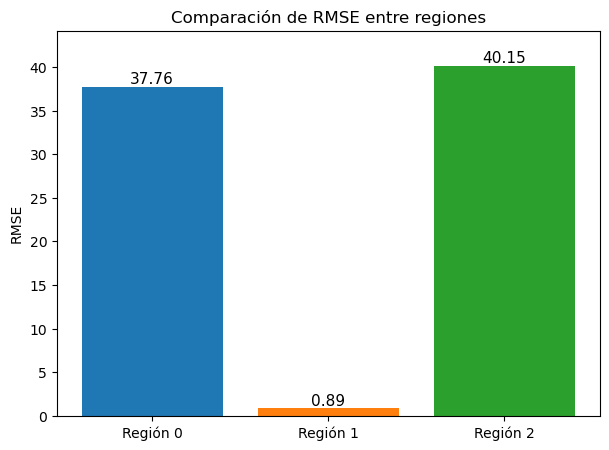

In [48]:
import matplotlib.pyplot as plt

rmse_values = []
region_names = []
for res in resultados:
    y_true = res['y_valid']
    y_pred = res['y_pred']
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    rmse_values.append(rmse)
    region_names.append(res['region'])

plt.figure(figsize=(7, 5))
bars = plt.bar(region_names, rmse_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('RMSE')
plt.title('Comparación de RMSE entre regiones')
plt.ylim(0, max(rmse_values)*1.1)
for bar, rmse in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{rmse:.2f}', 
             ha='center', va='bottom', fontsize=11)
plt.show()

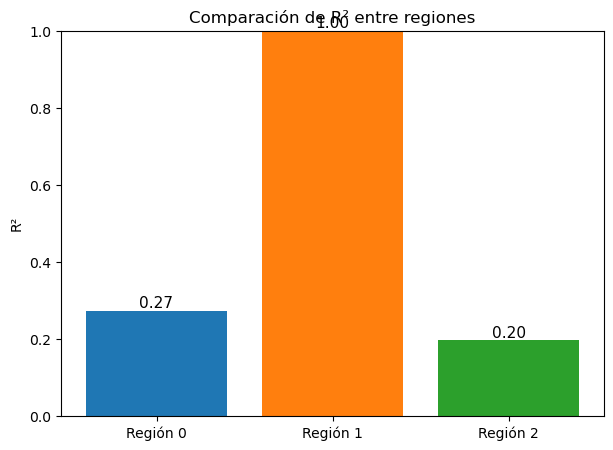

In [49]:
from sklearn.metrics import r2_score

r2_values = []
for res in resultados:
    y_true = res['y_valid']
    y_pred = res['y_pred']
    r2 = r2_score(y_true, y_pred)
    r2_values.append(r2)

plt.figure(figsize=(7, 5))
bars = plt.bar(region_names, r2_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('R²')
plt.title('Comparación de R² entre regiones')
plt.ylim(0, 1)
for bar, r2 in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{r2:.2f}', 
             ha='center', va='bottom', fontsize=11)
plt.show()

-------

## Resultados de entrenamiento y evaluación por Región

| Región    | RMSE   | R²      | Promedio predicho | Promedio real |
|-----------|--------|---------|-------------------|---------------|
| Región 0  | 37.76  | 0.2728  | 92.40             | 92.33         |
| Región 1  | 0.89   | 0.9996  | 68.71             | 68.73         |
| Región 2  | 40.15  | 0.1963  | 94.77             | 95.15         |

------

# **CALCULO DE COSTOS Y BENEFICIOS**

### Definición de las variables de negocio

In [50]:
inversion_total = 100_000_000
num_pozos = 200
valor_barril = 4.5
barriles_por_unidad = 1_000
valor_unidad = valor_barril * barriles_por_unidad
umbral_minimo_por_pozo = inversion_total / (num_pozos * valor_unidad)

### Comparar promedio de reservas predicho vs el umbral

| Región     | Umbral mínimo (unidades) | Promedio predicho (unidades) | ¿Supera el umbral? |
|------------|--------------------------|------------------------------|--------------------|
| Región 0   | 111.1                    | 92.40                        | No                 |
| Región 1   | 111.1                    | 68.71                        | No                 |
| Región 2   | 111.1                    | 94.77                        | No                 |


En ninguna de las regiones, el promedio predicho de reservas por pozo supera el umbral mínimo de 111.1 unidades requerido para evitar pérdidas. Por lo tanto, invertir en todos los pozos de cualquiera de las regiones sería riesgoso.

Sin embargo, el análisis continúa seleccionando los 200 pozos con mayor predicción en cada región, para evaluar si una estrategia selectiva puede ser rentable.


### Cálculo de ganancias de un conjunto de pozos seleccionados

In [ ]:
def calcular_ganancia_top_pozos(resultados, num_pozos, valor_unidad, inversion_total):
    top200_por_region = []
    for res in resultados:
        y_pred = res['y_pred']
        top_indices = np.argsort(y_pred)[-num_pozos:]
        top_preds = y_pred[top_indices]
        top200_por_region.append({'region': res['region'], 'top_preds': top_preds, 'indices': top_indices})
        suma_reservas = top_preds.sum()
        ganancia = suma_reservas * valor_unidad - inversion_total
        print(f"Ganancia esperada en {res['region']}: ${ganancia:,.2f}")
    return top200_por_region

In [75]:
# Ejecutar la función para calcular la ganancia esperada en cada región
top200_por_region = calcular_ganancia_top_pozos(resultados, 200, valor_unidad, inversion_total)


Ganancia esperada en Región 0: $38,966,584.80
Ganancia esperada en Región 1: $24,869,381.15
Ganancia esperada en Región 2: $33,779,815.14


### Resultados de las ganancias predichas por pozos por region

| Región     | Ganancia esperada (USD)    |
|------------|----------------------------|
| Región 0   | $38,966,584.80             |
| Región 1   | $24,869,381.15             |
| Región 2   | $33,779,815.14             |


“De acuerdo con las predicciones del modelo y la estrategia de seleccionar los 200 pozos con mayor reserva predicha, la Región 0 ofrece la mayor ganancia potencial para la empresa.”

-----

# **BOOTSTRAPPING**

In [83]:
top_preds_0 = top200_por_region[0]['top_preds']  # Esto es un arreglo con los 200 valores de predicción más altos
type(top_preds_0)

numpy.ndarray

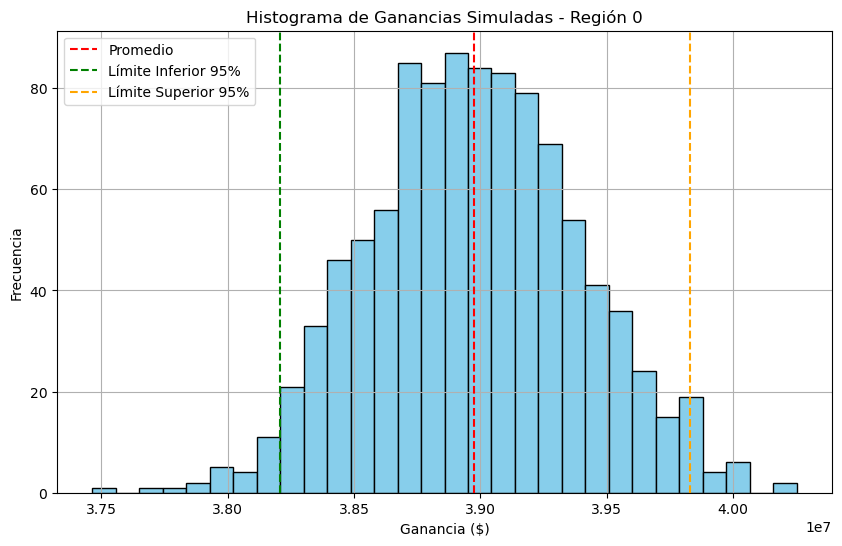


Resultados de Bootstrap para Región 0:
Promedio de ganancia: $38,975,078.71
Intervalo de confianza 95%: $38,208,605.58 a $39,830,052.26
Riesgo de pérdida: 0.00%


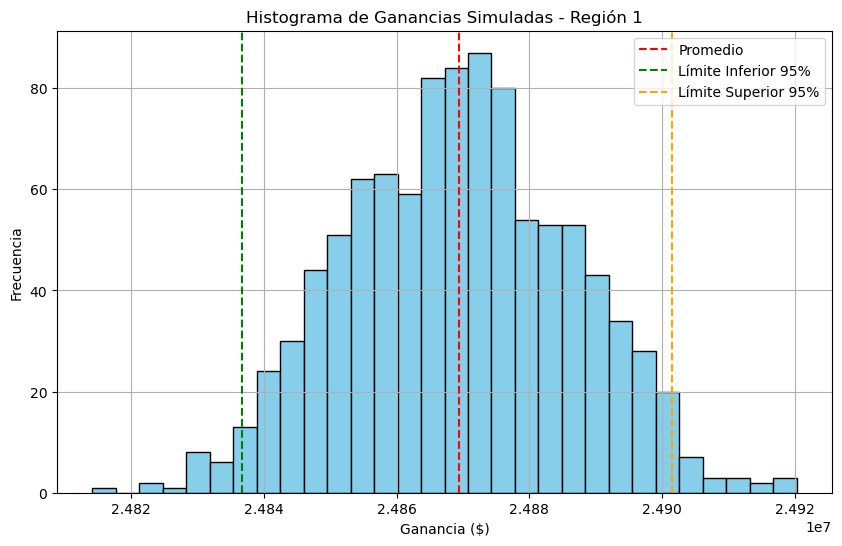


Resultados de Bootstrap para Región 1:
Promedio de ganancia: $24,869,430.94
Intervalo de confianza 95%: $24,836,692.38 a $24,901,588.55
Riesgo de pérdida: 0.00%


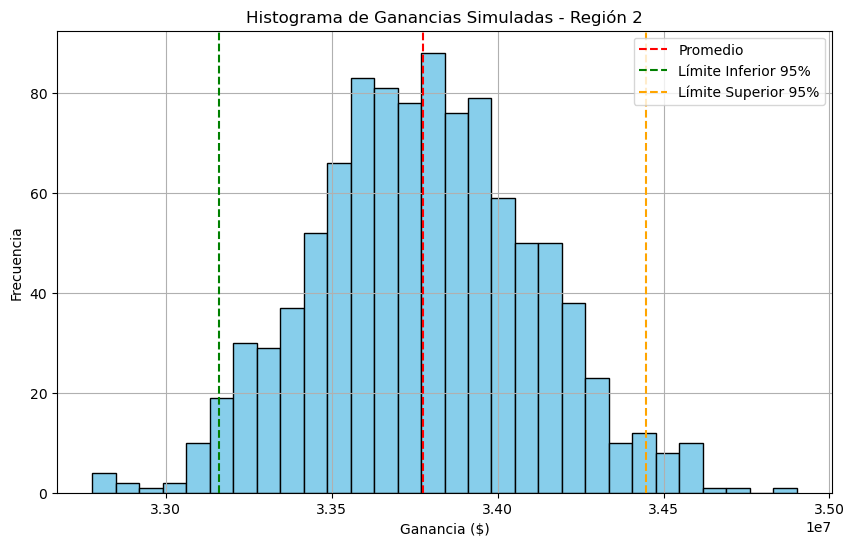


Resultados de Bootstrap para Región 2:
Promedio de ganancia: $33,775,932.63
Intervalo de confianza 95%: $33,159,871.11 a $34,446,734.96
Riesgo de pérdida: 0.00%


In [89]:
resultados_bootstrap = []

for region in top200_por_region:
    nombre = region['region']
    top_preds = region['top_preds']
    ganancias_simuladas = []
    for _ in range(1000):
        muestra = state.choice(top_preds, size=num_pozos, replace=True)
        suma = muestra.sum()
        ganancia = suma * valor_unidad - inversion_total
        ganancias_simuladas.append(ganancia)
    ganancias_simuladas = np.array(ganancias_simuladas)
    promedio = ganancias_simuladas.mean()
    intervalo_inf, intervalo_sup = np.percentile(ganancias_simuladas, [2.5, 97.5])
    riesgo = (ganancias_simuladas < 0).mean() * 100

    # Graficar el histograma de las ganancias simuladas
    plt.figure(figsize=(10, 6))
    plt.hist(ganancias_simuladas, bins=30, color='skyblue', edgecolor='black')
    plt.axvline(x=promedio, color='red', linestyle='--', label='Promedio')
    plt.axvline(x=intervalo_inf, color='green', linestyle='--', label='Límite Inferior 95%')
    plt.axvline(x=intervalo_sup, color='orange', linestyle='--', label='Límite Superior 95%')
    plt.title(f'Histograma de Ganancias Simuladas - {nombre}')
    plt.xlabel('Ganancia ($)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid()
    plt.show()
    

    resultados_bootstrap.append({
        'region': nombre,
        'promedio': promedio,
        'intervalo_inf': intervalo_inf,
        'intervalo_sup': intervalo_sup,
        'riesgo': riesgo,
    })

    # Imprimir resultados para cada región
    print(f"\nResultados de Bootstrap para {nombre}:")
    print(f"Promedio de ganancia: ${promedio:,.2f}")
    print(f"Intervalo de confianza 95%: ${intervalo_inf:,.2f} a ${intervalo_sup:,.2f}")
    print(f"Riesgo de pérdida: {riesgo:.2f}%")
    

# **CONCLUSIONES**

"De acuerdo con el análisis realizado, todas las regiones cumplen con el criterio de riesgo aceptable (0% de probabilidad de pérdida según bootstrapping).
Sin embargo, la Región 0 presenta el mayor promedio de ganancia esperada, por lo que se recomienda seleccionar esta región para el desarrollo de los 200 nuevos pozos petrolíferos."